In [1]:
# Script for training a denoiser on KappaTNG
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

from absl import app
from absl import flags

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
import optax

from jax_lensing.inversion import ks93, ks93inv
from jax_lensing.utils import load_dataset

from astropy.io import fits

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset = "kappatng"
batch_size = 2
map_size = 360
train_split = "80%"
noise_dist_std = 0.2

In [4]:
# Let's prepare some test data
def load_dataset():
    # test  set
    def pre_process(im):
        x = tf.image.random_crop(tf.expand_dims(im['map'],-1), [map_size,map_size,1])
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        # Sample random Gaussian noise
        u = tf.random.normal(tf.shape(x))
        # Sample standard deviation of noise corruption
        s = noise_dist_std * tf.random.normal((1, 1, 1))
        # Create noisy image
        y = x + s * u
        return {'x':x, 'y':y, 'u':u,'s':s}
    ds = tfds.load('kappatng', split='train[-20%:]', shuffle_files=False)
    ds = ds.map(pre_process)
    return iter(tfds.as_numpy(ds))

In [5]:
test_set = load_dataset()

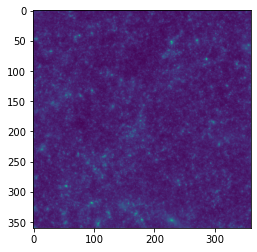

In [6]:
# Instantiate dataset and sample map
ref_map = next(test_set)['x']
ref_map.shape
imshow(ref_map[...,0])

In [7]:
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

In [8]:
# We turn it into shear
e1, e2 = ks93inv(ref_map[...,0], jnp.zeros_like(ref_map[...,0]))
# And we extract a patch that put the big cluster right at the edge

k = ref_map[...,0]

(-0.5, 359.5, 359.5, -0.5)

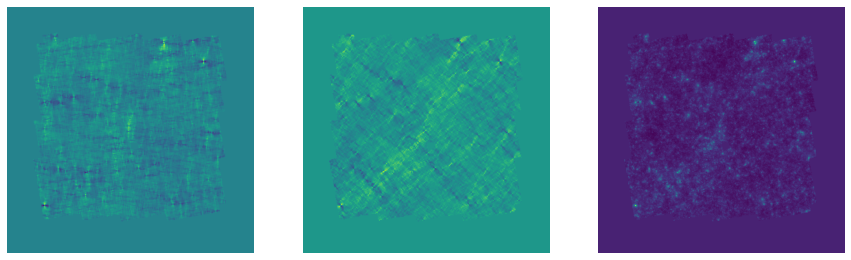

In [9]:
figure(figsize=[15,5])
subplot(131)
imshow(e1*mask)
axis('off')

subplot(132)
imshow(e2*mask)
axis('off')

subplot(133)
imshow(k*mask)
axis('off')

**Compare with True COSMOS shear noise**

0.14842281


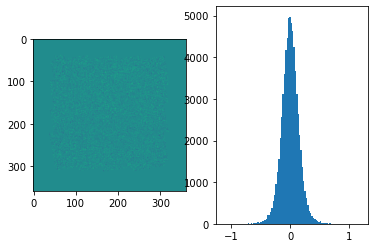

In [10]:

cosmos_e1 = fits.getdata('../data/COSMOS/cosmos_full_e1_0.29arcmin360.fits').astype('float32')
subplot(121)
imshow(cosmos_e1)
subplot(122)
m = cosmos_e1 == 0
hist(cosmos_e1[~m], 100);
print(jnp.std(cosmos_e1[~m]))

In [11]:
# import ellipticities
e1 = fits.getdata('../data/COSMOS/e1.fits').astype('float32')
e2 = fits.getdata('../data/COSMOS/e2.fits').astype('float32')

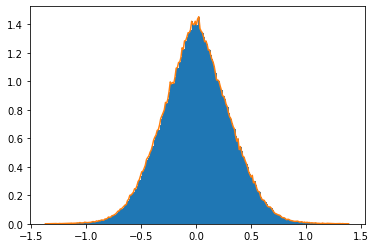

In [12]:
import jax.numpy as jnp
a, b = jnp.histogram(e1, 256, density=True)
hist(e1, 256, density=True);
plot(b[:-1], a)

### Fit a Gaussian

In [13]:
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

In [170]:
N = 256
coords = np.linspace(-1,1,N)

def model(var):
    dist = tfp.distributions.Normal(loc=0., scale=var)
    return dist.prob(coords)

In [171]:
params = jnp.ones(1)*.1
x = model(params)

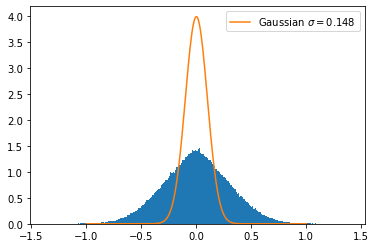

In [172]:
hist(e1, 256, density=True);
plot(coords, x, label=r'Gaussian $\sigma=0.148$')
legend()

In [173]:
from jax.scipy.optimize import minimize

loss = lambda p: jnp.sum((a - model(p))**2)

In [174]:
results = minimize(loss, params, method='BFGS')

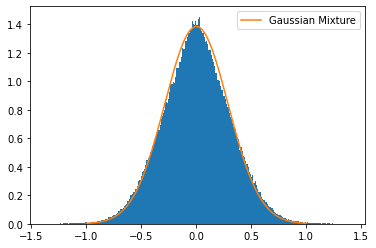

In [175]:
results.x, results.nit
z = model(results.x)
hist(e1, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

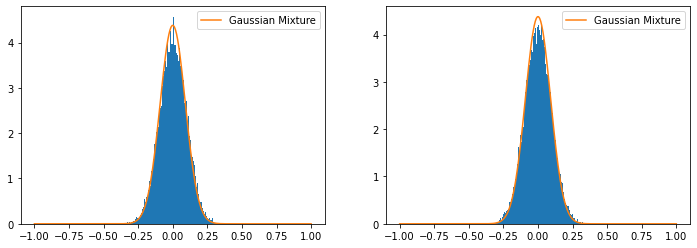

In [176]:
e1_10 = e1[:-7].reshape((-1,10)).mean(axis=-1)
e2_10 = e2[:-7].reshape((-1,10)).mean(axis=-1)

figure(figsize=[12,4])
subplot(121)
z = model(results.x/jnp.sqrt(10))
hist(e1_10, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

subplot(122)
z = model(results.x/jnp.sqrt(10))
hist(e2_10, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

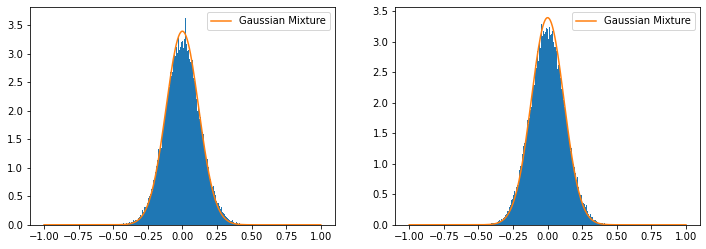

In [177]:
e1_6 = e1[:-3].reshape((-1,6)).mean(axis=-1)
e2_6 = e2[:-3].reshape((-1,6)).mean(axis=-1)

figure(figsize=[12,4])
subplot(121)
z = model(results.x/jnp.sqrt(6))
hist(e1_6, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

subplot(122)
z = model(results.x/jnp.sqrt(6))
hist(e2_6, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

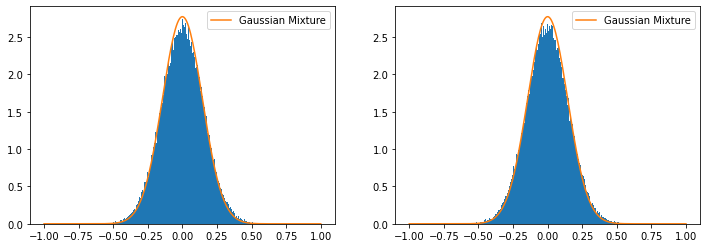

In [178]:
e1_4 = e1[:-1].reshape((-1,4)).mean(axis=-1)
e2_4 = e2[:-1].reshape((-1,4)).mean(axis=-1)

figure(figsize=[12,4])
subplot(121)
z = model(results.x/jnp.sqrt(4))
hist(e1_4, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

subplot(122)
z = model(results.x/jnp.sqrt(4))
hist(e2_4, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

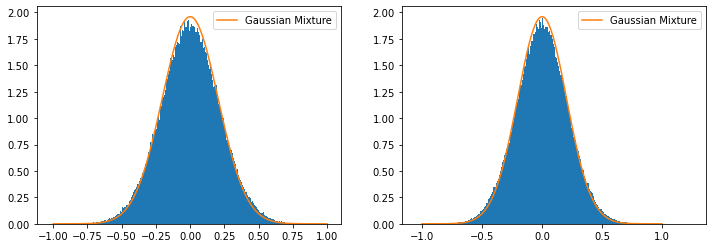

In [179]:
e1_2 = e1[:-1].reshape((-1,2)).mean(axis=-1)
e2_2 = e2[:-1].reshape((-1,2)).mean(axis=-1)

figure(figsize=[12,4])
subplot(121)
z = model(results.x/jnp.sqrt(2))
hist(e1_2, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

subplot(122)
z = model(results.x/jnp.sqrt(2))
hist(e2_2, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

### Fit a Mixture of 2 Gaussians

In [180]:
def model(params):
    mix1 = params[0]
    mix2 = params[1]
    loc1 = 0.#params[2]
    scale1 = params[2]
    loc2 = 0.#params[4]
    scale2 = params[3]
    
    bimix_gauss = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[mix1, mix2]),
        components_distribution=tfd.Normal(
            loc=[loc1, loc2],       # One for each component.
            scale=[scale1, scale2]))  # And same here.
            
    return bimix_gauss.prob(coords)

In [181]:
params = jnp.array([0.5, 0.5, .4, .3])
y = model(params)

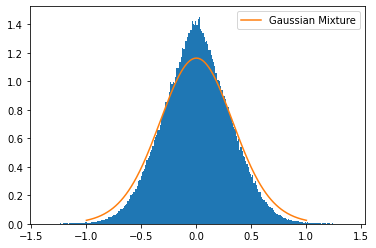

In [182]:
hist(e1, 256, density=True);
plot(coords, y, label=r'Gaussian Mixture')
legend()

In [183]:
loss = lambda p: jnp.sum((a - model(p))**2)

In [184]:
"""
learning_rate = 1e-4
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)
grads = jax.grad(loss)(params)
for i in range(1000):
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
"""

results2 = minimize(loss, params, method='BFGS')

In [185]:
results2.x
#params

DeviceArray([0.5, 0.5, 0.4, 0.3], dtype=float32)

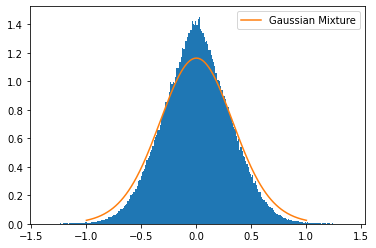

In [186]:
z = model(results2.x)
#z = model(params)
hist(e1, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

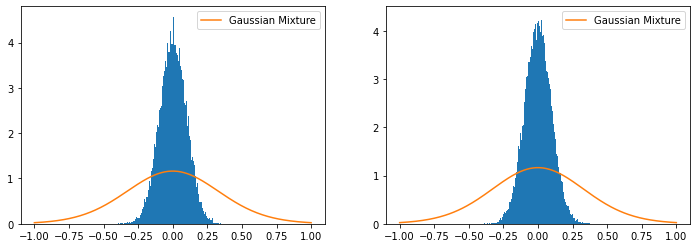

In [187]:
e1_10 = e1[:-7].reshape((-1,10)).mean(axis=-1)
e2_10 = e2[:-7].reshape((-1,10)).mean(axis=-1)

figure(figsize=[12,4])
subplot(121)
p = np.array(results2.x)
p[:-2] /= jnp.sqrt(10)
z = model(p)
hist(e1_10, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

subplot(122)
p = np.array(results2.x)
p[:-2] /= jnp.sqrt(10)
z = model(p)
hist(e2_10, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

### Fit a Mixture of 3 Gaussians

In [92]:
def model(params):
    mix1 = params[0]
    mix2 = params[1]
    mix3 = params[2]
    loc1 = 0.#params[3]
    scale1 = params[3]
    loc2 = 0.#params[5]
    scale2 = params[4]
    loc3 = 0.#params[7]
    scale3 = params[5]
    
    bimix_gauss = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[mix1, mix2, mix3]),
        components_distribution=tfd.Normal(
            loc=[loc1, loc2, loc3],       # One for each component.
            scale=[scale1, scale2, scale3]))  # And same here.
            
    return bimix_gauss.prob(coords)

In [93]:
params = jnp.array([0.6, 0.3, 0.1, .3, .2, .3])
y = model(params)

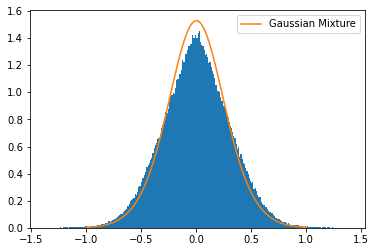

In [94]:
hist(e1, 256, density=True);
plot(coords, y, label=r'Gaussian Mixture')
legend()

In [95]:
loss = lambda p: jnp.sum((a - model(p))**2)

"""
learning_rate = 1e-4
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)
grads = jax.grad(loss)(params)
for i in range(100):
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
"""

    
results = minimize(loss, params, method='BFGS')
print(results.x, results.nit)

[0.5302978  0.4374856  0.10824089 0.63233525 0.1456174  0.2836106 ] 4


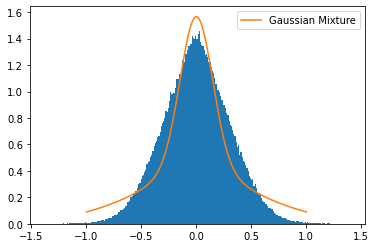

In [96]:
#z = model(params)
z = model(results.x)
hist(e1, 256, density=True);
plot(coords, z, label=r'Gaussian Mixture')
legend()

In [32]:
print('phi_1=',results.x[0])
print('phi_2=',results.x[1])
print('phi_3=',results.x[2])
#print('loc_1=',results.x[3])
print('scale_1=',results.x[3])
#print('loc_2=',results.x[5])
print('scale_2=',results.x[4])
#print('loc_3=',results.x[7])
print('scale_3=',results.x[5])

phi_1= 0.5302978
phi_2= 0.4374856
phi_3= 0.108240895
scale_1= 0.63233525
scale_2= 0.1456174
scale_3= 0.2836106


In [33]:
n_gal = fits.getdata('../data/COSMOS/cosmos_full_ngal_0.29arcmin360.fits').astype('float32')

6.0284863


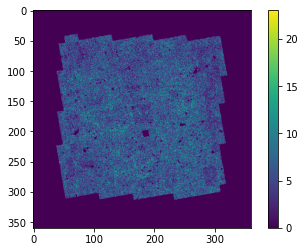

In [34]:
print(np.mean(n_gal[n_gal>0]))
imshow(n_gal)
colorbar()

In [35]:
e1_6 = e1[:-3].reshape((-1,6)).mean(axis=-1)
e2_6 = e2[:-3].reshape((-1,6)).mean(axis=-1)

In [36]:
sigma_noise = 0.148 # We have a noise of 0.148

In [37]:
# And, last but not least, we can also include reduced shear
g1 = e1 / (1 - k)
g2 = e2 / (1 - k)

ValueError: operands could not be broadcast together with shapes (417117,) (360,360) 

In [ ]:
subplot(131)
imshow(e1)
subplot(132)
imshow(g1 + sigma_noise*randn(map_size,map_size))
subplot(133)
mock_cosmos_e1 = mask*(g1 + sigma_noise*randn(map_size,map_size))
m = mock_cosmos_e1 == 0
hist(mock_cosmos_e1[~m], 100);
print(jnp.std(mock_cosmos_e1[~m]))

In [ ]:
# We can save for testing this map with added noise
#fits.writeto('../data/ktng/ktng_cosmos_kappa{}.fits'.format(map_size),k)
#fits.writeto('../data/ktng/ktng_cosmos_e{}.fits'.format(map_size),
#              np.stack([mask*(g1 + sigma_noise*randn(map_size,map_size)),
#                        mask*(g2 + sigma_noise*randn(map_size,map_size))],axis=-1))

In [ ]:
1+1

In [79]:
e1[:-7].shape[0] / 10

41711.0